In [77]:
import os
import sys
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from IPython.display import Audio

import keras

In [113]:
Ravdess = "/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/"
Crema = "/home/kenterbery/projects/speech_emotion_recognition/input/Crema/"
Savee = "/home/kenterbery/projects/speech_emotion_recognition/input/Savee/"
Tess = "/home/kenterbery/projects/speech_emotion_recognition/input/Tess/"

Ravdess dataset

In [114]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, Ravdess + dir + "/" + wav))

[(2,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-02-01-01-01-13.wav'),
 (2,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-02-02-01-01-13.wav'),
 (7,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-07-02-01-02-13.wav'),
 (7,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-07-02-02-01-13.wav'),
 (7,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-07-01-01-01-13.wav'),
 (5,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-05-01-02-02-13.wav'),
 (5,
  '/home/kenterbery/projects/speech_emotion_recognition/input/Ravdess/audio_speech_actors_01-24/Actor_13/03-01-05-01-02-01-13.wav'),
 (3,
  '/home/kenterbery/projects/

In [115]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [116]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,neutral,/home/kenterbery/projects/speech_emotion_recog...
1,neutral,/home/kenterbery/projects/speech_emotion_recog...
2,disgust,/home/kenterbery/projects/speech_emotion_recog...
3,disgust,/home/kenterbery/projects/speech_emotion_recog...
4,disgust,/home/kenterbery/projects/speech_emotion_recog...


Crema dataset


In [117]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + wav))
    else:
        emotion_df.append(("unknown", Crema + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,disgust,/home/kenterbery/projects/speech_emotion_recog...
1,happy,/home/kenterbery/projects/speech_emotion_recog...
2,sad,/home/kenterbery/projects/speech_emotion_recog...
3,happy,/home/kenterbery/projects/speech_emotion_recog...
4,neutral,/home/kenterbery/projects/speech_emotion_recog...


TESS dataset

In [118]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(Tess + dir):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", Tess + dir + "/" + wav))
        else:
            emotion_df.append((emo, Tess + dir + "/" + wav))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,sad,/home/kenterbery/projects/speech_emotion_recog...
1,sad,/home/kenterbery/projects/speech_emotion_recog...
2,sad,/home/kenterbery/projects/speech_emotion_recog...
3,sad,/home/kenterbery/projects/speech_emotion_recog...
4,sad,/home/kenterbery/projects/speech_emotion_recog...


In [119]:
savee_directiory_list = os.listdir(Savee)

emotion_df = []

for wav in savee_directiory_list:
    info = wav.partition(".wav")[0].split("_")[1].replace(r"[0-9]", "")
    emotion = re.split(r"[0-9]", info)[0]
    if emotion=='a':
        emotion_df.append(("angry", Savee + wav))
    elif emotion=='d':
        emotion_df.append(("disgust", Savee + wav))
    elif emotion=='f':
        emotion_df.append(("fear", Savee + wav))
    elif emotion=='h':
        emotion_df.append(("happy", Savee + wav))
    elif emotion=='n':
        emotion_df.append(("neutral", Savee + wav))
    elif emotion=='sa':
        emotion_df.append(("sad", Savee + wav))
    else:
        emotion_df.append(("surprise", Savee + wav))


Savee_df = pd.DataFrame.from_dict(emotion_df)
Savee_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Savee_df.head()

,Emotion,Path
0,sad,/home/kenterbery/projects/speech_emotion_recog...
1,neutral,/home/kenterbery/projects/speech_emotion_recog...
2,disgust,/home/kenterbery/projects/speech_emotion_recog...
3,angry,/home/kenterbery/projects/speech_emotion_recog...
4,disgust,/home/kenterbery/projects/speech_emotion_recog...


In [120]:
df = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
df.shape

(12162, 2)

In [121]:
df.head()

,Emotion,Path
0,neutral,/home/kenterbery/projects/speech_emotion_recog...
1,neutral,/home/kenterbery/projects/speech_emotion_recog...
2,disgust,/home/kenterbery/projects/speech_emotion_recog...
3,disgust,/home/kenterbery/projects/speech_emotion_recog...
4,disgust,/home/kenterbery/projects/speech_emotion_recog...


### Exploratory data analysis


In [122]:
%matplotlib inline

plt.style.use("ggplot")

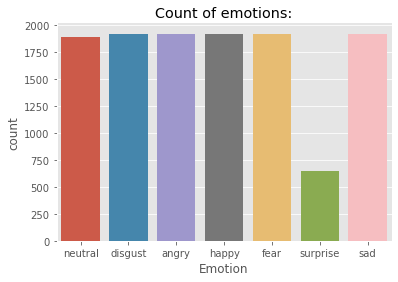

In [123]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [132]:
def create_waveplot(data, sr, emo):
    plt.figure(figsize=(10,3))
    plt.title(f"Waveplot for .wav with {emo} emotion")
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emo):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12,3))
    plt.title(f"Spectrogram for .wav with {emo} emotion")
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz")
    # librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar()


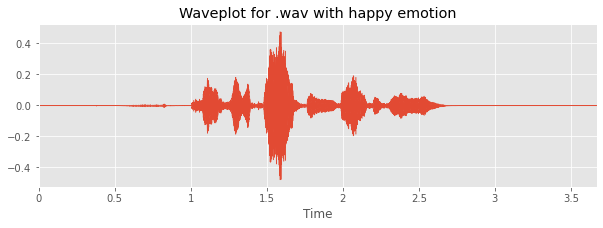

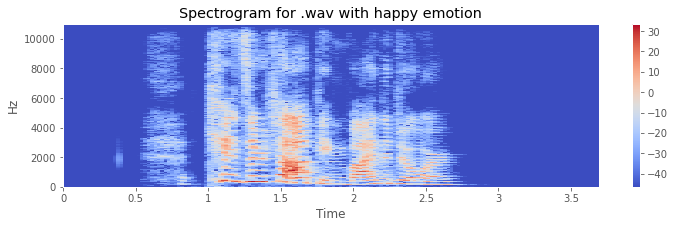

In [135]:
emotion = "happy"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

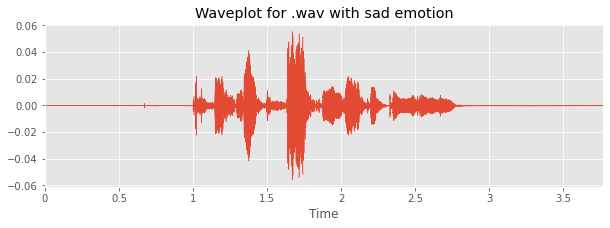

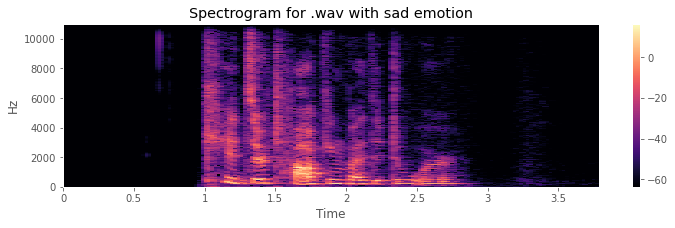

In [136]:

emotion = "sad"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

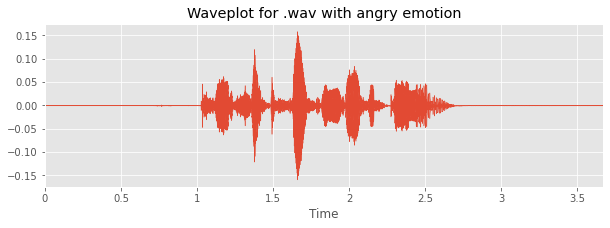

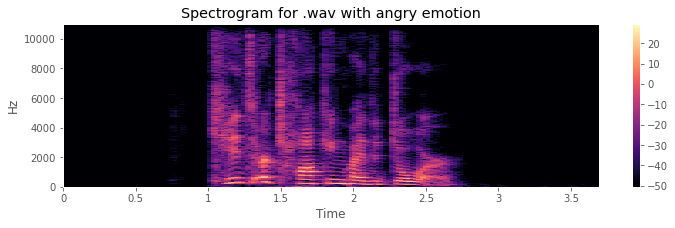

In [137]:
emotion = "angry"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
emotion = "fear"
path = np.array(df["Path"][df["Emotion"] == emotion])[100]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Data augmentation

In [169]:
def noise(data, rate=0.035):
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [147]:
path = np.array(df.Path)[100]
data, sampling_rate = librosa.load(path)

1. Simple audio

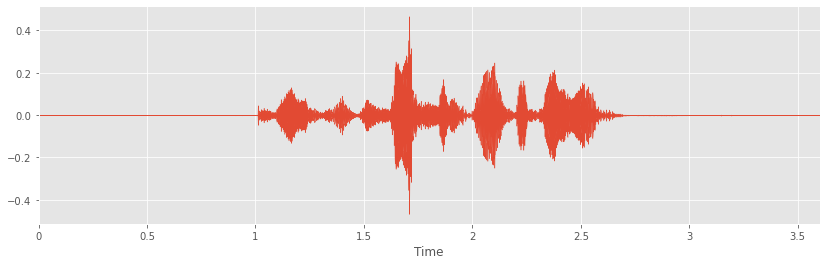

In [148]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

2. Noised audio

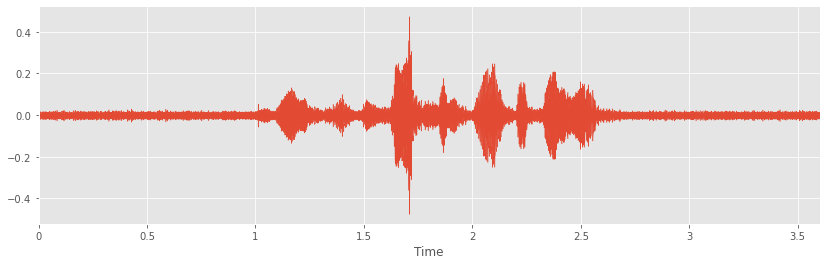

In [153]:
noised_data = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


3. Stretching


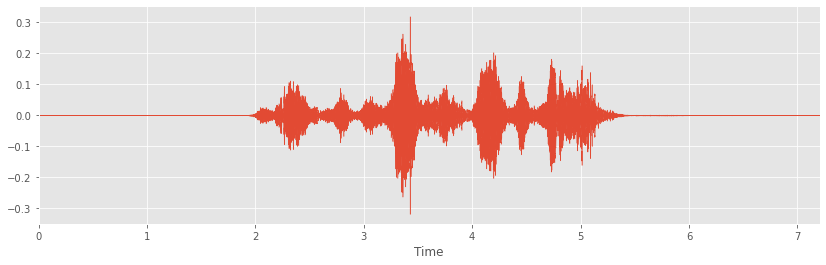

In [155]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

4. Shifting


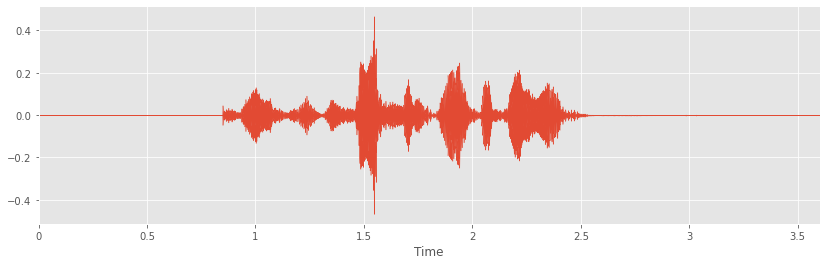

In [168]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


5. Pitching

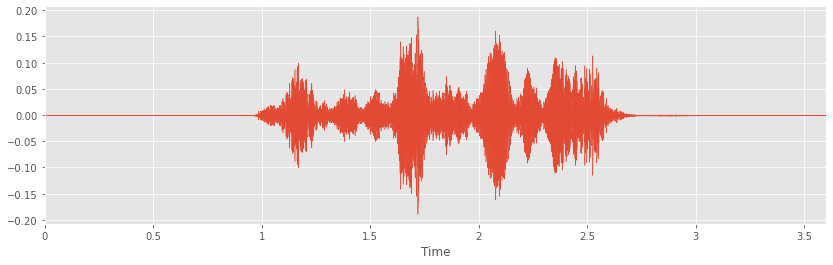

In [173]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For data augmentation we will use noise, shift and pitch


### Feature extraction

#### Features that may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [328]:
# Zero Crossing Rate
def zcr(data):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    return zcr


def energy(data, frame_length=512, hop_length=256):
    en = np.array([np.sum(np.power(data[hop:hop+frame_length], 2)) for hop in range(0, data.shape[0], hop_length)])
    return en


def rmse(data):
    rmse = np.mean(librosa.feature.rms(y=data).T, axis=0)
    return rmse


def entropy_of_energy(data):
    rms = librosa.feature.rms(y=data)
    rms = np.squeeze(rms)
    return rms



In [334]:
path = np.array(df.Path)[10]
data, sampling_rate = librosa.load(path)

In [335]:
en = energy(data)

#

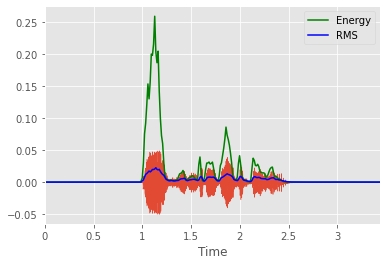

In [336]:
rms = librosa.feature.rms(y=data, frame_length=512, hop_length=256)
rms = np.squeeze(rms)
# rms.shape
frames = range(len(rms))
t = librosa.frames_to_time(frames, sr=sampling_rate, hop_length=256)
#
librosa.display.waveplot(data, sr=sampling_rate)
plt.plot(t, en, label="Energy", c="g")
plt.plot(t, rms, label="RMS", c="b")
plt.legend()
plt.show()